# Variational Auto-Encoder (VAE)

### Zhenwen Dai (2018-8-21)

In [1]:
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference
%matplotlib inline
from pylab import *

/Users/zhenwend/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load a toy dataset

In [2]:
import GPy
data = GPy.util.datasets.oil_100()
Y = data['X']
label = data['Y'].argmax(1)

In [3]:
N, D = Y.shape

## Model Defintion

In [4]:
Q = 2

In [5]:
H = 50
encoder = nn.HybridSequential(prefix='encoder_')
with encoder.name_scope():
    encoder.add(nn.Dense(H, activation="tanh"))
    encoder.add(nn.Dense(H, activation="tanh"))
    encoder.add(nn.Dense(Q, flatten=True))
encoder.initialize(mx.init.Xavier(magnitude=3))
_=encoder(mx.nd.array(np.random.rand(5,D)))

In [6]:
H = 50
decoder = nn.HybridSequential(prefix='decoder_')
with decoder.name_scope():
    decoder.add(nn.Dense(H, activation="tanh"))
    decoder.add(nn.Dense(H, activation="tanh"))
    decoder.add(nn.Dense(D, flatten=True))
decoder.initialize(mx.init.Xavier(magnitude=3))
_=decoder(mx.nd.array(np.random.rand(5,Q)))

In [7]:
from mxfusion.components.var_trans import PositiveTransformation

In [8]:
m = mf.models.Model()
m.N = mf.components.Variable()
m.decoder = mf.components.functions.MXFusionGluonFunction(decoder, nOutputs=1,broadcastable=False)
m.x = mf.components.distributions.Normal.define_variable(mean=mx.nd.array([0]), variance=mx.nd.array([1]), shape=(m.N, Q))
m.f = m.decoder(m.x)
m.noise_var = mf.components.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([0.01]))
m.y = mf.components.distributions.Normal.define_variable(mean=m.f, variance=m.noise_var, shape=(m.N, D))
m.show()

x ~ Normal(mean=Variable(61c66), variance=Variable(3581c))
f = GluonFunctionEvaluation(decoder_dense0_weight=Variable(1e112), decoder_dense0_bias=Variable(12aa9), decoder_dense1_weight=Variable(d74ee), decoder_dense1_bias=Variable(e16ac), decoder_dense2_weight=Variable(9a998), decoder_dense2_bias=Variable(f53b6), decoder_input_0=x)
y ~ Normal(mean=f, variance=noise_var)


In [9]:
q = mf.models.Posterior(m)
q.x_var = mf.components.Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=mx.nd.array([1e-6]))
q.encoder = mf.components.functions.MXFusionGluonFunction(encoder, nOutputs=1, broadcastable=False)
q.x_mean = q.encoder(q.y)
q.x.set_prior(mf.components.distributions.Normal(mean=q.x_mean, variance=q.x_var))
q.show()

x_mean = GluonFunctionEvaluation(encoder_dense0_weight=Variable(2b695), encoder_dense0_bias=Variable(dc41f), encoder_dense1_weight=Variable(a3272), encoder_dense1_bias=Variable(5387d), encoder_dense2_weight=Variable(75bd2), encoder_dense2_bias=Variable(b470d), encoder_input_0=y)
x ~ Normal(mean=x_mean, variance=x_var)


## Variational Inference

In [10]:
from mxfusion.inference import BatchInferenceLoop, StochasticVariationalInference, GradBasedInference

In [11]:
observed = [m.y]
alg = StochasticVariationalInference(num_samples=3, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [12]:
infr.run(max_iter=2000, learning_rate=1e-2, y=mx.nd.array(Y), verbose=True)

 /Users/zhenwend/mxfusion/src/MXFusion/mxfusion/inference/inference_parameters.py:52: UserWarning:InferenceParameters has already been initialized.  The existing one will be overwritten.
 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:689: UserWarning:Parameter 'decoder_dense0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:689: UserWarning:Parameter 'decoder_dense0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:689: UserWarning:Parameter 'decoder_dense1_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:689: UserWarning:Parameter 'decoder_dense1_bias' is already initialized, ignoring. Set force_reinit=True to re-initializ

Iteration 1 logL: -1460.925048828125
Iteration 2 logL: -1562.58935546875
Iteration 3 logL: -1281.037109375
Iteration 4 logL: -1202.09814453125
Iteration 5 logL: -1215.446533203125
Iteration 6 logL: -1242.7581787109375
Iteration 7 logL: -1206.203125
Iteration 8 logL: -1193.624755859375
Iteration 9 logL: -1133.6195068359375
Iteration 10 logL: -1112.78466796875
Iteration 11 logL: -1098.210205078125
Iteration 12 logL: -1090.024169921875
Iteration 13 logL: -1077.6949462890625
Iteration 14 logL: -1074.197021484375
Iteration 15 logL: -1060.966796875
Iteration 16 logL: -1047.22314453125
Iteration 17 logL: -1042.4344482421875
Iteration 18 logL: -1035.609619140625
Iteration 19 logL: -1028.633544921875
Iteration 20 logL: -1029.137939453125
Iteration 21 logL: -1024.3011474609375
Iteration 22 logL: -1023.6302490234375
Iteration 23 logL: -1019.930908203125
Iteration 24 logL: -1010.139892578125
Iteration 25 logL: -1006.3385009765625
Iteration 26 logL: -1000.4537353515625
Iteration 27 logL: -994.98229

Iteration 220 logL: -298.33416748046875
Iteration 221 logL: -320.0117492675781
Iteration 222 logL: -312.9443359375
Iteration 223 logL: -322.6186218261719
Iteration 224 logL: -299.63201904296875
Iteration 225 logL: -309.0345458984375
Iteration 226 logL: -297.46710205078125
Iteration 227 logL: -304.5844421386719
Iteration 228 logL: -296.8038330078125
Iteration 229 logL: -289.9383239746094
Iteration 230 logL: -273.607666015625
Iteration 231 logL: -273.5848388671875
Iteration 232 logL: -274.6050720214844
Iteration 233 logL: -279.795654296875
Iteration 234 logL: -265.371337890625
Iteration 235 logL: -268.1728210449219
Iteration 236 logL: -286.056640625
Iteration 237 logL: -258.6797180175781
Iteration 238 logL: -263.93536376953125
Iteration 239 logL: -246.6587371826172
Iteration 240 logL: -252.12295532226562
Iteration 241 logL: -238.30902099609375
Iteration 242 logL: -242.0396728515625
Iteration 243 logL: -278.215576171875
Iteration 244 logL: -252.17807006835938
Iteration 245 logL: -262.0987

Iteration 435 logL: 225.4755401611328
Iteration 436 logL: 213.35824584960938
Iteration 437 logL: 202.34970092773438
Iteration 438 logL: 228.9705810546875
Iteration 439 logL: 198.14373779296875
Iteration 440 logL: 244.12088012695312
Iteration 441 logL: 236.96514892578125
Iteration 442 logL: 203.80783081054688
Iteration 443 logL: 218.20977783203125
Iteration 444 logL: 246.59051513671875
Iteration 445 logL: 243.72267150878906
Iteration 446 logL: 229.65682983398438
Iteration 447 logL: 250.5946044921875
Iteration 448 logL: 256.8073425292969
Iteration 449 logL: 256.71893310546875
Iteration 450 logL: 261.1754455566406
Iteration 451 logL: 244.5701904296875
Iteration 452 logL: 227.1672821044922
Iteration 453 logL: 264.9158020019531
Iteration 454 logL: 214.1546630859375
Iteration 455 logL: 226.58258056640625
Iteration 456 logL: 254.49893188476562
Iteration 457 logL: 209.53927612304688
Iteration 458 logL: 250.943115234375
Iteration 459 logL: 267.63482666015625
Iteration 460 logL: 270.447814941406

Iteration 657 logL: 536.2933349609375
Iteration 658 logL: 549.052734375
Iteration 659 logL: 571.5628051757812
Iteration 660 logL: 552.716064453125
Iteration 661 logL: 557.7147216796875
Iteration 662 logL: 554.8577880859375
Iteration 663 logL: 466.18133544921875
Iteration 664 logL: 368.4473571777344
Iteration 665 logL: 360.48773193359375
Iteration 666 logL: 438.94110107421875
Iteration 667 logL: 572.2512817382812
Iteration 668 logL: 472.37847900390625
Iteration 669 logL: 530.16064453125
Iteration 670 logL: 553.6785888671875
Iteration 671 logL: 515.496337890625
Iteration 672 logL: 546.71826171875
Iteration 673 logL: 558.7097778320312
Iteration 674 logL: 536.4127197265625
Iteration 675 logL: 552.5570678710938
Iteration 676 logL: 563.292236328125
Iteration 677 logL: 493.20703125
Iteration 678 logL: 495.22198486328125
Iteration 679 logL: 554.2552490234375
Iteration 680 logL: 551.2715454101562
Iteration 681 logL: 563.9290771484375
Iteration 682 logL: 600.485107421875
Iteration 683 logL: 573.

Iteration 887 logL: 838.1316528320312
Iteration 888 logL: 844.7845458984375
Iteration 889 logL: 887.7886352539062
Iteration 890 logL: 868.22265625
Iteration 891 logL: 813.8795166015625
Iteration 892 logL: 796.704345703125
Iteration 893 logL: 793.932861328125
Iteration 894 logL: 867.7857666015625
Iteration 895 logL: 856.1488037109375
Iteration 896 logL: 843.4646606445312
Iteration 897 logL: 868.587890625
Iteration 898 logL: 854.2940673828125
Iteration 899 logL: 876.6920776367188
Iteration 900 logL: 873.056396484375
Iteration 901 logL: 831.32470703125
Iteration 902 logL: 838.5699462890625
Iteration 903 logL: 830.3270874023438
Iteration 904 logL: 802.0255126953125
Iteration 905 logL: 809.5960693359375
Iteration 906 logL: 822.2182006835938
Iteration 907 logL: 873.634765625
Iteration 908 logL: 875.795166015625
Iteration 909 logL: 862.3692626953125
Iteration 910 logL: 850.43310546875
Iteration 911 logL: 833.352294921875
Iteration 912 logL: 849.2166748046875
Iteration 913 logL: 902.6884765625

Iteration 1111 logL: 962.6839599609375
Iteration 1112 logL: 881.141357421875
Iteration 1113 logL: 860.9453125
Iteration 1114 logL: 998.08642578125
Iteration 1115 logL: 1001.9853515625
Iteration 1116 logL: 884.92822265625
Iteration 1117 logL: 877.4230346679688
Iteration 1118 logL: 998.454345703125
Iteration 1119 logL: 1001.0167236328125
Iteration 1120 logL: 936.878662109375
Iteration 1121 logL: 1004.7036743164062
Iteration 1122 logL: 976.13134765625
Iteration 1123 logL: 909.76953125
Iteration 1124 logL: 954.080322265625
Iteration 1125 logL: 1003.7349243164062
Iteration 1126 logL: 1011.4635620117188
Iteration 1127 logL: 938.172607421875
Iteration 1128 logL: 990.42236328125
Iteration 1129 logL: 999.8948974609375
Iteration 1130 logL: 981.76708984375
Iteration 1131 logL: 958.307861328125
Iteration 1132 logL: 1012.425048828125
Iteration 1133 logL: 1025.4129638671875
Iteration 1134 logL: 994.3681640625
Iteration 1135 logL: 1007.59375
Iteration 1136 logL: 1030.0966796875
Iteration 1137 logL: 9

Iteration 1331 logL: 1042.868408203125
Iteration 1332 logL: 965.0197143554688
Iteration 1333 logL: 1022.3446655273438
Iteration 1334 logL: 1112.038330078125
Iteration 1335 logL: 1114.69189453125
Iteration 1336 logL: 1079.322509765625
Iteration 1337 logL: 1043.923583984375
Iteration 1338 logL: 1049.371826171875
Iteration 1339 logL: 1058.91015625
Iteration 1340 logL: 1086.10595703125
Iteration 1341 logL: 1026.8619384765625
Iteration 1342 logL: 1050.6318359375
Iteration 1343 logL: 1062.94970703125
Iteration 1344 logL: 1031.307861328125
Iteration 1345 logL: 980.0872802734375
Iteration 1346 logL: 1037.4945068359375
Iteration 1347 logL: 1095.67236328125
Iteration 1348 logL: 1066.962158203125
Iteration 1349 logL: 1024.1964111328125
Iteration 1350 logL: 1004.3167114257812
Iteration 1351 logL: 1067.9764404296875
Iteration 1352 logL: 1083.7701416015625
Iteration 1353 logL: 1068.117431640625
Iteration 1354 logL: 1092.052978515625
Iteration 1355 logL: 1078.3023681640625
Iteration 1356 logL: 1075.7

Iteration 1552 logL: 1152.974365234375
Iteration 1553 logL: 1143.1324462890625
Iteration 1554 logL: 1146.483642578125
Iteration 1555 logL: 1146.3553466796875
Iteration 1556 logL: 1157.802978515625
Iteration 1557 logL: 1145.6148681640625
Iteration 1558 logL: 1150.203857421875
Iteration 1559 logL: 1158.2666015625
Iteration 1560 logL: 1152.2862548828125
Iteration 1561 logL: 1175.57568359375
Iteration 1562 logL: 1168.501708984375
Iteration 1563 logL: 1170.6280517578125
Iteration 1564 logL: 1142.899169921875
Iteration 1565 logL: 1165.309814453125
Iteration 1566 logL: 1151.5889892578125
Iteration 1567 logL: 1168.0517578125
Iteration 1568 logL: 1137.4246826171875
Iteration 1569 logL: 1146.2012939453125
Iteration 1570 logL: 1152.290283203125
Iteration 1571 logL: 1122.83447265625
Iteration 1572 logL: 1111.770751953125
Iteration 1573 logL: 1129.753173828125
Iteration 1574 logL: 1140.9453125
Iteration 1575 logL: 1104.6373291015625
Iteration 1576 logL: 1144.629638671875
Iteration 1577 logL: 1156.2

Iteration 1773 logL: 1029.544189453125
Iteration 1774 logL: 1103.8106689453125
Iteration 1775 logL: 1160.5919189453125
Iteration 1776 logL: 1131.671142578125
Iteration 1777 logL: 1128.98046875
Iteration 1778 logL: 1189.90185546875
Iteration 1779 logL: 1136.0472412109375
Iteration 1780 logL: 1103.69775390625
Iteration 1781 logL: 1176.66650390625
Iteration 1782 logL: 1156.9439697265625
Iteration 1783 logL: 1018.382568359375
Iteration 1784 logL: 1121.1993408203125
Iteration 1785 logL: 1174.5164794921875
Iteration 1786 logL: 1138.939697265625
Iteration 1787 logL: 1201.796630859375
Iteration 1788 logL: 1161.7603759765625
Iteration 1789 logL: 1155.3951416015625
Iteration 1790 logL: 1175.95263671875
Iteration 1791 logL: 1190.130126953125
Iteration 1792 logL: 1173.4368896484375
Iteration 1793 logL: 1192.296875
Iteration 1794 logL: 1189.837646484375
Iteration 1795 logL: 1180.27734375
Iteration 1796 logL: 1200.889892578125
Iteration 1797 logL: 1175.4337158203125
Iteration 1798 logL: 1159.1953125

Iteration 1990 logL: 1222.82470703125
Iteration 1991 logL: 1200.0384521484375
Iteration 1992 logL: 1195.4183349609375
Iteration 1993 logL: 1223.42919921875
Iteration 1994 logL: 1202.7012939453125
Iteration 1995 logL: 1181.566650390625
Iteration 1996 logL: 1211.32568359375
Iteration 1997 logL: 1247.471435546875
Iteration 1998 logL: 1243.31005859375
Iteration 1999 logL: 1203.407470703125
Iteration 2000 logL: 1221.434326171875


## Plot the training data in the latent space

In [13]:
q_x_mean = q.encoder.block(mx.nd.array(Y)).asnumpy()

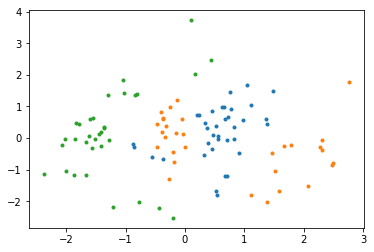

In [14]:
for i in range(3):
    plot(q_x_mean[label==i,0], q_x_mean[label==i,1], '.')